# Лабораторная работа 3. Градиентный бустинг.
## Булыгин Максим

Подключаем библиотеки.

In [7]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

Импортируем данные.

In [8]:
df = pd.read_csv('winequality-red.csv', sep = ";")

In [9]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Проверяем данные.

In [10]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Заметим, что в каждом столбце есть "аномально-большие" наблюдения. Посмотрим на ящики с усами, возможно у нас много выбросов.

In [11]:
df.boxplot(figsize=(20,10), rot=45, fontsize=15)

Из картинки ничего не понятно, так как данные несопоставимы. Для определения количества выбросов стандартизуем данные и посмотрим на ящики с усами стандартизованных данных.

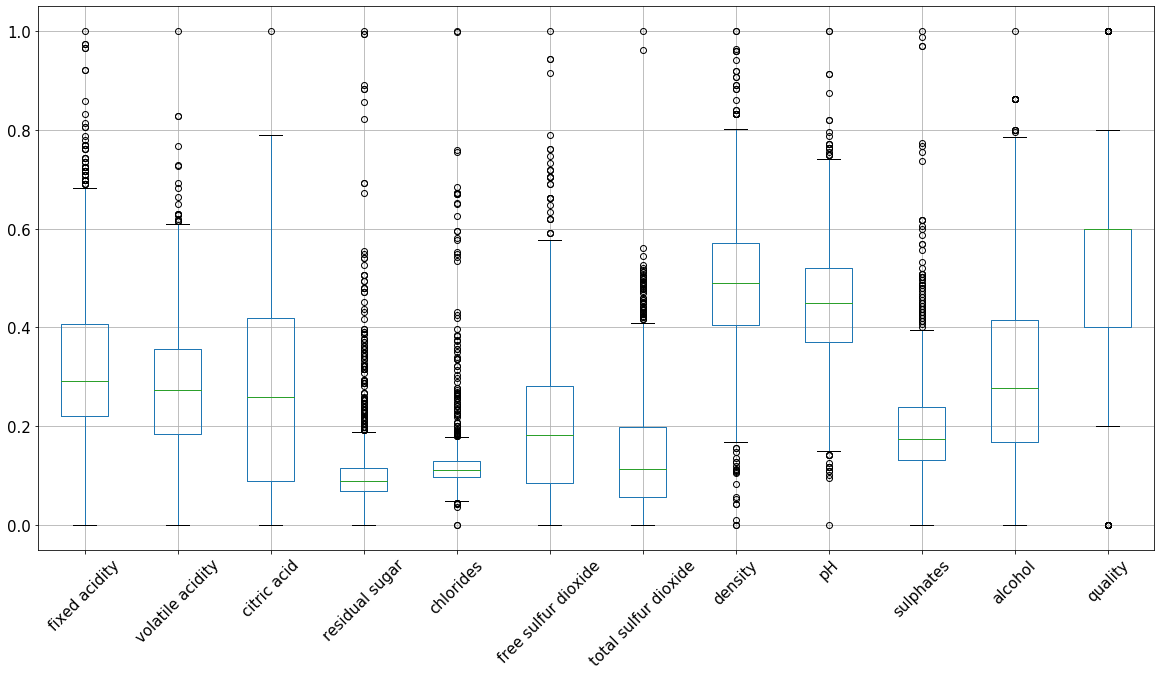

In [12]:
from sklearn import preprocessing
stand = preprocessing.MinMaxScaler()
df_standed = df.copy()
df_standed[list(df.columns)] = stand.fit_transform(df)
df_standed.boxplot(figsize=(20,10), rot=45, fontsize=15)

Огромное количество выбросов. Возможно наши переменные имеют нормальное распределение и мы сможем воспользоваться правилом трех сигм и удалить наблюдения в каждом столбце, выходящие за интервал $(\bar{y} - \sigma, \bar{y} - \sigma)$? Проверим гипотезы о нормальности распределения наших переменных.

In [13]:
for col in set(df.columns):
    if stats.shapiro(df[col])[1] > 0.05:
        print("Так как p-value > 0.05, то не отколоняем нулевую гипотезу о нормальности распределения:\n\
        переменная " + col + " имеет нормальное распределение с вероятностью 0.95")
    else:
        print("Так как p-value < 0.05, то отколоняем нулевую гипотезу о нормальности распределения:\n\
        переменная " + col + " не имеет нормальное распределение с вероятностью 0.95")

Так как p-value < 0.05, то отколоняем нулевую гипотезу о нормальности распределения:
        переменная free sulfur dioxide не имеет нормальное распределение с вероятностью 0.95
Так как p-value < 0.05, то отколоняем нулевую гипотезу о нормальности распределения:
        переменная citric acid не имеет нормальное распределение с вероятностью 0.95
Так как p-value < 0.05, то отколоняем нулевую гипотезу о нормальности распределения:
        переменная quality не имеет нормальное распределение с вероятностью 0.95
Так как p-value < 0.05, то отколоняем нулевую гипотезу о нормальности распределения:
        переменная fixed acidity не имеет нормальное распределение с вероятностью 0.95
Так как p-value < 0.05, то отколоняем нулевую гипотезу о нормальности распределения:
        переменная volatile acidity не имеет нормальное распределение с вероятностью 0.95
Так как p-value < 0.05, то отколоняем нулевую гипотезу о нормальности распределения:
        переменная density не имеет нормальное распред

Возможно они имеют log-нормальное распределение?

In [14]:
for col in set(df.columns):
    if stats.shapiro(np.log(df[col]))[1] > 0.05:
        print("Так как p-value > 0.05, то не отколоняем нулевую гипотезу о нормальности распределения:\n\
        переменная " + col + " имеет нормальное распределение с вероятностью 0.95")
    else:
        print("Так как p-value < 0.05, то отколоняем нулевую гипотезу о нормальности распределения:\n\
        переменная " + col + " не имеет нормальное распределение с вероятностью 0.95")

Так как p-value < 0.05, то отколоняем нулевую гипотезу о нормальности распределения:
        переменная free sulfur dioxide не имеет нормальное распределение с вероятностью 0.95
Так как p-value > 0.05, то не отколоняем нулевую гипотезу о нормальности распределения:
        переменная citric acid имеет нормальное распределение с вероятностью 0.95
Так как p-value < 0.05, то отколоняем нулевую гипотезу о нормальности распределения:
        переменная quality не имеет нормальное распределение с вероятностью 0.95
Так как p-value < 0.05, то отколоняем нулевую гипотезу о нормальности распределения:
        переменная fixed acidity не имеет нормальное распределение с вероятностью 0.95
Так как p-value < 0.05, то отколоняем нулевую гипотезу о нормальности распределения:
        переменная volatile acidity не имеет нормальное распределение с вероятностью 0.95
Так как p-value < 0.05, то отколоняем нулевую гипотезу о нормальности распределения:
        переменная density не имеет нормальное распред

C:\Games\anaconda\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Как видим, наши параметры не имеют ни нормальное, ни log-нормальное распределение. Нужно удалять выбросы по-другому.

Огромное количество наблюений выходит за верхний "ус" ящика, то есть их значения больше $Q_3 + 1.5(Q_3 - Q_1)$. Выбросы будут искажать и портить модель классификации. Удаляем выбросы: удалим наблюдения, выходищяие за предел "усов" (нижних и верхних) ящиков с усами. Придется жертвовать количеством наблюдений.

In [15]:
# находим верхние и нижние границы ящиков с усами
bound = []
for i in list(df.columns):
    q1 = df[i].quantile(q=0.25)
    q3 = df[i].quantile(q=0.75)
    bound.append([q1 - 1.5 * (q3 - q1), q3 + 1.5 * (q3 - q1)])
bound

[[3.95, 12.349999999999998],
 [0.015000000000000013, 1.0150000000000001],
 [-0.4049999999999999, 0.9149999999999999],
 [0.8499999999999996, 3.6500000000000004],
 [0.04000000000000002, 0.11999999999999998],
 [-14.0, 42.0],
 [-38.0, 122.0],
 [0.9922475000000002, 1.0011874999999997],
 [2.925, 3.6849999999999996],
 [0.28000000000000014, 0.9999999999999999],
 [7.1000000000000005, 13.5],
 [3.5, 7.5]]

Создадим копию датафрейма, в которой будем удалять наблюдения, выходящие за верхние и нижние границы ящиков с усами.

In [16]:
col = list(df.columns)
df1 = df.copy()
for i in range(len(bound)):
    df1 = df1[(df1[col[i]] > bound[i][0]) & (df1[col[i]] < bound[i][1])]

Исправилась ли ситуация?

In [17]:
df1.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000
mean,8.161650,0.522963,0.246760,2.184524,0.078588,14.984694,42.124150,0.996581,3.324600,0.631318,10.352452,5.624150
std,1.459478,0.164364,0.179571,0.440907,0.014325,8.763159,25.929986,0.001594,0.131856,0.116241,0.964454,0.721626
min,5.100000,0.120000,0.000000,1.200000,0.041000,1.000000,6.000000,0.992360,2.940000,0.330000,8.700000,4.000000
25%,7.100000,0.390000,0.080000,1.900000,0.069000,8.000000,22.000000,0.995520,3.230000,0.550000,9.500000,5.000000
50%,7.800000,0.520000,0.240000,2.100000,0.078000,13.000000,36.000000,0.996600,3.330000,0.610000,10.100000,6.000000
75%,9.000000,0.630000,0.390000,2.500000,0.087000,20.000000,56.000000,0.997600,3.410000,0.700000,11.000000,6.000000
max,12.300000,1.005000,0.730000,3.600000,0.119000,41.000000,121.000000,1.001000,3.680000,0.980000,13.400000,7.000000


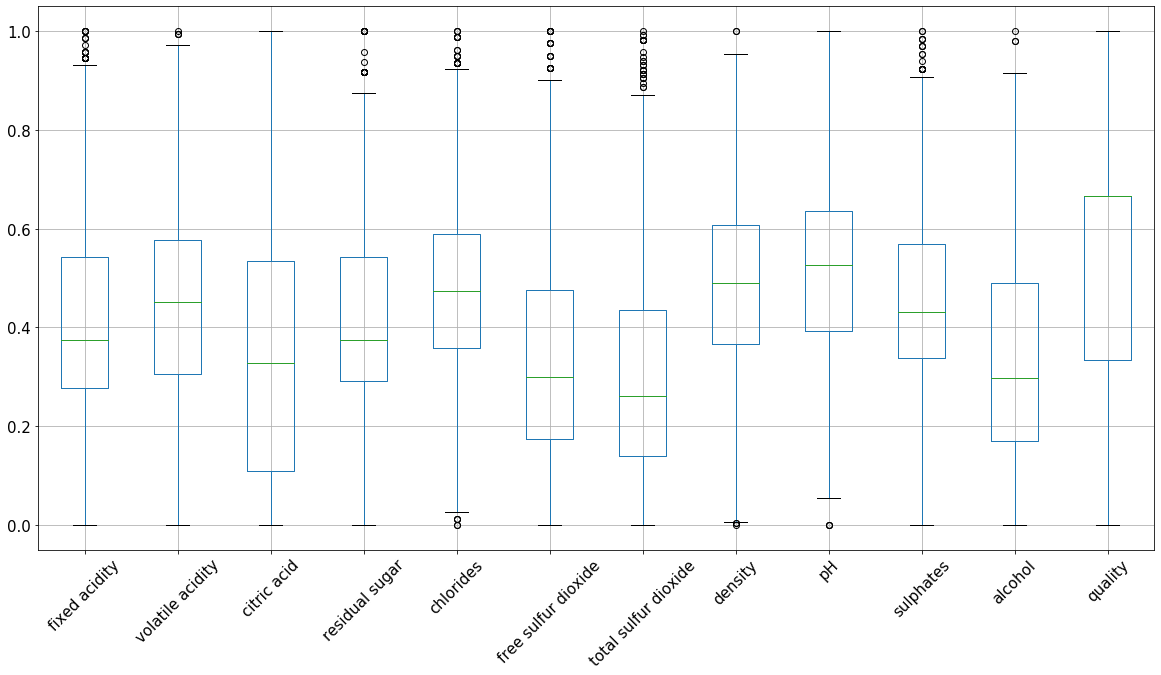

In [18]:
df1_standed = df1.copy()
df1_standed[list(df1.columns)] = stand.fit_transform(df1)
df1_standed.boxplot(figsize=(20,10), rot=45, fontsize=15)

Ситуация лучше, но все еще много выбросов. Продолжаем удалять выбросы.

In [19]:
bound = []
for i in list(df.columns):
    q1 = df1[i].quantile(q=0.25)
    q3 = df1[i].quantile(q=0.75)
    bound.append([q1 - 1.5 * (q3 - q1), q3 + 1.5 * (q3 - q1)])
for i in range(len(bound)):
    df1 = df1[(df1[col[i]] > bound[i][0]) & (df1[col[i]] < bound[i][1])]

In [20]:
df1.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000
mean,8.072945,0.523169,0.238480,2.162380,0.077712,14.673040,40.475143,0.996513,3.331329,0.624637,10.350510,5.631931
std,1.344087,0.164465,0.174093,0.417319,0.013076,8.225191,23.737376,0.001539,0.126441,0.109979,0.958775,0.725010
min,5.200000,0.120000,0.000000,1.200000,0.043000,1.000000,6.000000,0.992420,2.980000,0.330000,8.700000,4.000000
25%,7.100000,0.390000,0.080000,1.900000,0.069000,8.000000,22.000000,0.995500,3.250000,0.550000,9.500000,5.000000
50%,7.800000,0.520000,0.230000,2.100000,0.078000,13.000000,35.000000,0.996560,3.330000,0.610000,10.100000,6.000000
75%,8.900000,0.635000,0.380000,2.400000,0.086000,20.000000,54.000000,0.997457,3.410000,0.690000,11.000000,6.000000
max,11.800000,0.980000,0.730000,3.400000,0.113000,37.000000,106.000000,1.000600,3.680000,0.920000,13.000000,7.000000


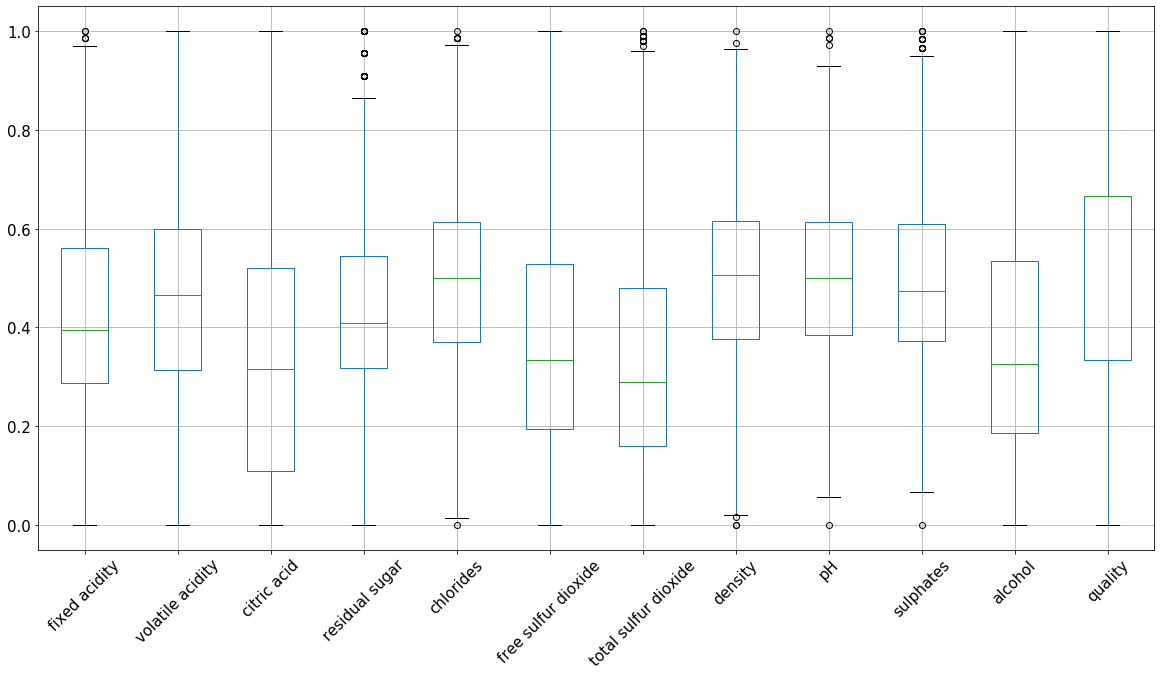

In [21]:
df1_standed = df1.copy()
df1_standed[list(df1.columns)] = stand.fit_transform(df1)
df1_standed.boxplot(figsize=(20,10), rot=45, fontsize=15)

Еще раз.

In [22]:
bound = []
for i in list(df.columns):
    q1 = df1[i].quantile(q=0.25)
    q3 = df1[i].quantile(q=0.75)
    bound.append([q1 - 1.5 * (q3 - q1), q3 + 1.5 * (q3 - q1)])
for i in range(len(bound)):
    df1 = df1[(df1[col[i]] > bound[i][0]) & (df1[col[i]] < bound[i][1])]

In [23]:
df1.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000,967.000000
mean,8.014891,0.522244,0.234767,2.128232,0.077355,14.572906,39.435367,0.996443,3.333992,0.622647,10.355567,5.638056
std,1.300766,0.163570,0.172482,0.374538,0.012698,8.127899,22.535817,0.001466,0.123429,0.105169,0.951989,0.718953
min,5.200000,0.120000,0.000000,1.200000,0.044000,1.000000,6.000000,0.992580,3.020000,0.370000,8.700000,4.000000
25%,7.100000,0.390000,0.080000,1.900000,0.069000,8.000000,22.000000,0.995500,3.255000,0.550000,9.500000,5.000000
50%,7.700000,0.520000,0.230000,2.100000,0.077000,13.000000,35.000000,0.996490,3.340000,0.600000,10.100000,6.000000
75%,8.800000,0.635000,0.370000,2.400000,0.085000,19.000000,52.000000,0.997400,3.410000,0.685000,11.000000,6.000000
max,11.600000,0.980000,0.690000,3.100000,0.111000,37.000000,101.000000,1.000240,3.630000,0.890000,13.000000,7.000000


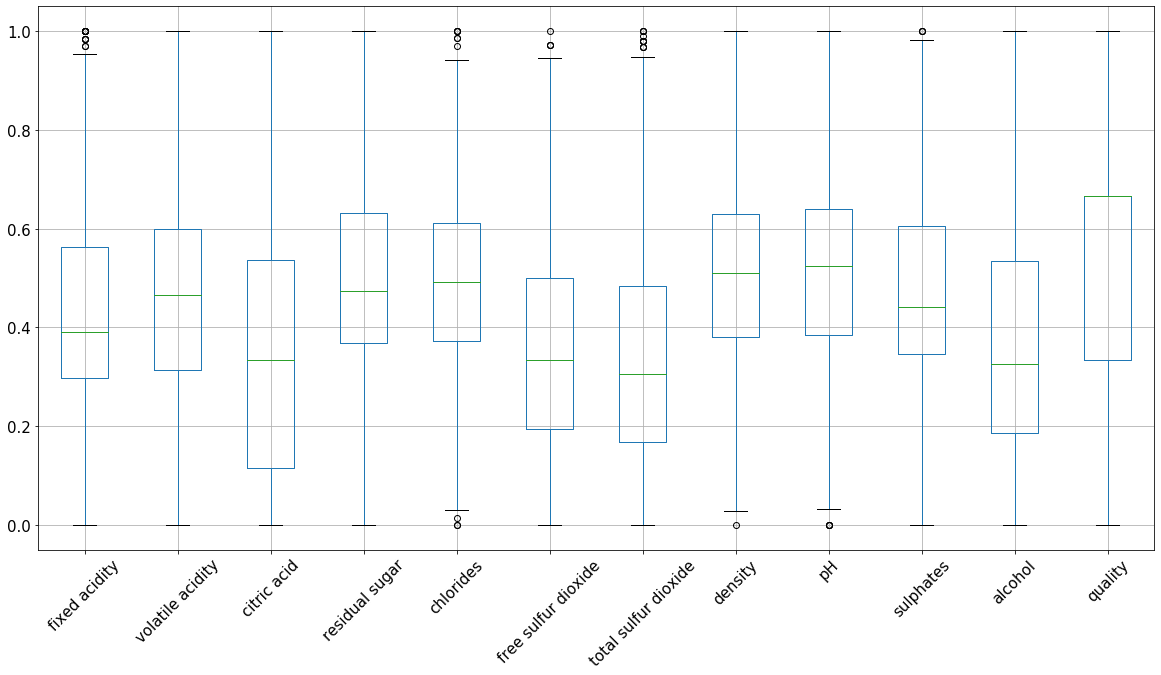

In [24]:
df1_standed = df1.copy()
df1_standed[list(df1.columns)] = stand.fit_transform(df1)
df1_standed.boxplot(figsize=(20,10), rot=45, fontsize=15)

Еще раз.

In [25]:
bound = []
for i in list(df.columns):
    q1 = df1[i].quantile(q=0.25)
    q3 = df1[i].quantile(q=0.75)
    bound.append([q1 - 1.5 * (q3 - q1), q3 + 1.5 * (q3 - q1)])
for i in range(len(bound)):
    df1 = df1[(df1[col[i]] > bound[i][0]) & (df1[col[i]] < bound[i][1])]

In [26]:
df1.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000,925.000000
mean,7.964432,0.523530,0.229535,2.128324,0.077169,14.429189,38.725405,0.996436,3.337546,0.621384,10.344829,5.634595
std,1.223321,0.164655,0.168357,0.369520,0.012252,8.005856,21.750162,0.001437,0.119795,0.104293,0.947036,0.718112
min,5.200000,0.120000,0.000000,1.200000,0.046000,1.000000,6.000000,0.992800,3.040000,0.370000,8.700000,4.000000
25%,7.100000,0.390000,0.080000,1.900000,0.069000,8.000000,22.000000,0.995500,3.260000,0.550000,9.500000,5.000000
50%,7.700000,0.520000,0.230000,2.100000,0.077000,13.000000,34.000000,0.996500,3.340000,0.600000,10.100000,6.000000
75%,8.800000,0.640000,0.360000,2.400000,0.085000,19.000000,52.000000,0.997400,3.410000,0.680000,11.000000,6.000000
max,11.300000,0.980000,0.680000,3.100000,0.109000,35.000000,96.000000,1.000200,3.620000,0.880000,13.000000,7.000000


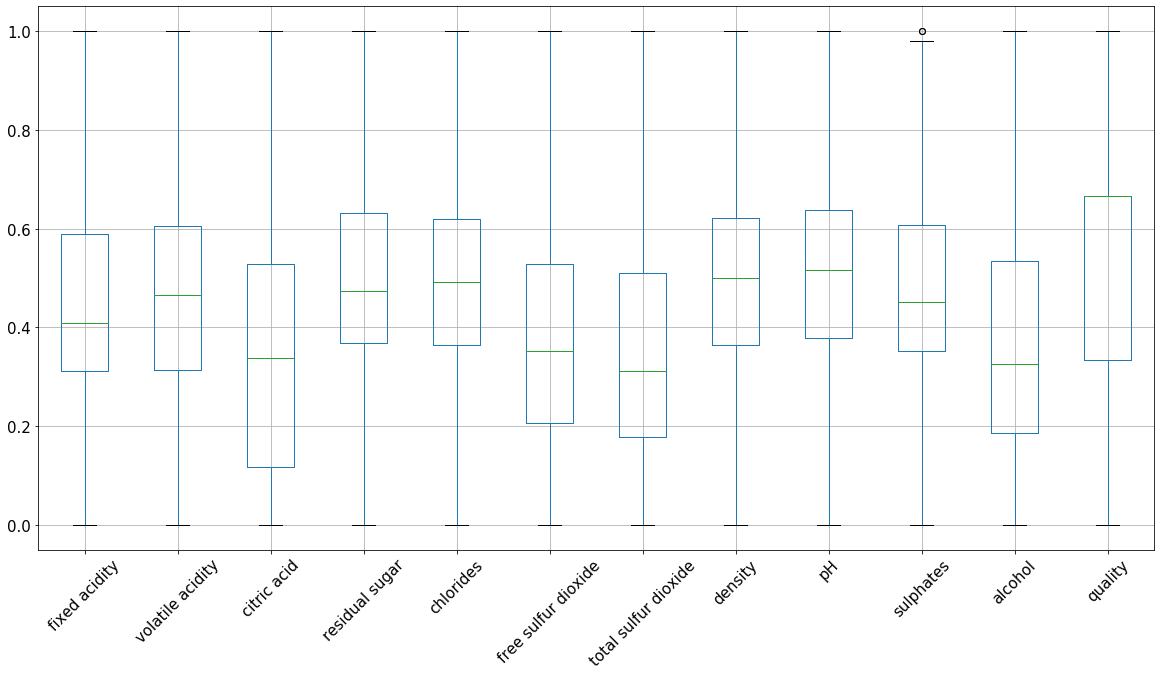

In [27]:
df1_standed = df1.copy()
df1_standed[list(df1.columns)] = stand.fit_transform(df1)
df1_standed.boxplot(figsize=(20,10), rot=45, fontsize=15)

Ситуация исправилась. Остался всего один выброс. Уберем его вручную.

In [28]:
df1 = df1[df1["sulphates"] < df1["sulphates"].quantile(q=0.75) 
    + 1.5 * (df1["sulphates"].quantile(q=0.75) - df1["sulphates"].quantile(q=0.25))]

In [29]:
df1.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000
mean,7.960888,0.523982,0.228982,2.127952,0.077197,14.421452,38.736728,0.996436,3.337595,0.620823,10.342434,5.631636
std,1.220530,0.164545,0.168060,0.369717,0.012241,7.996410,21.761900,0.001437,0.119920,0.103708,0.945626,0.716066
min,5.200000,0.120000,0.000000,1.200000,0.046000,1.000000,6.000000,0.992800,3.040000,0.370000,8.700000,4.000000
25%,7.100000,0.390000,0.080000,1.900000,0.069000,8.000000,22.000000,0.995500,3.260000,0.550000,9.500000,5.000000
50%,7.700000,0.520000,0.230000,2.100000,0.077000,13.000000,34.000000,0.996500,3.340000,0.600000,10.100000,6.000000
75%,8.800000,0.640000,0.360000,2.400000,0.085000,19.000000,52.000000,0.997400,3.410000,0.680000,11.000000,6.000000
max,11.300000,0.980000,0.680000,3.100000,0.109000,35.000000,96.000000,1.000200,3.620000,0.870000,13.000000,7.000000


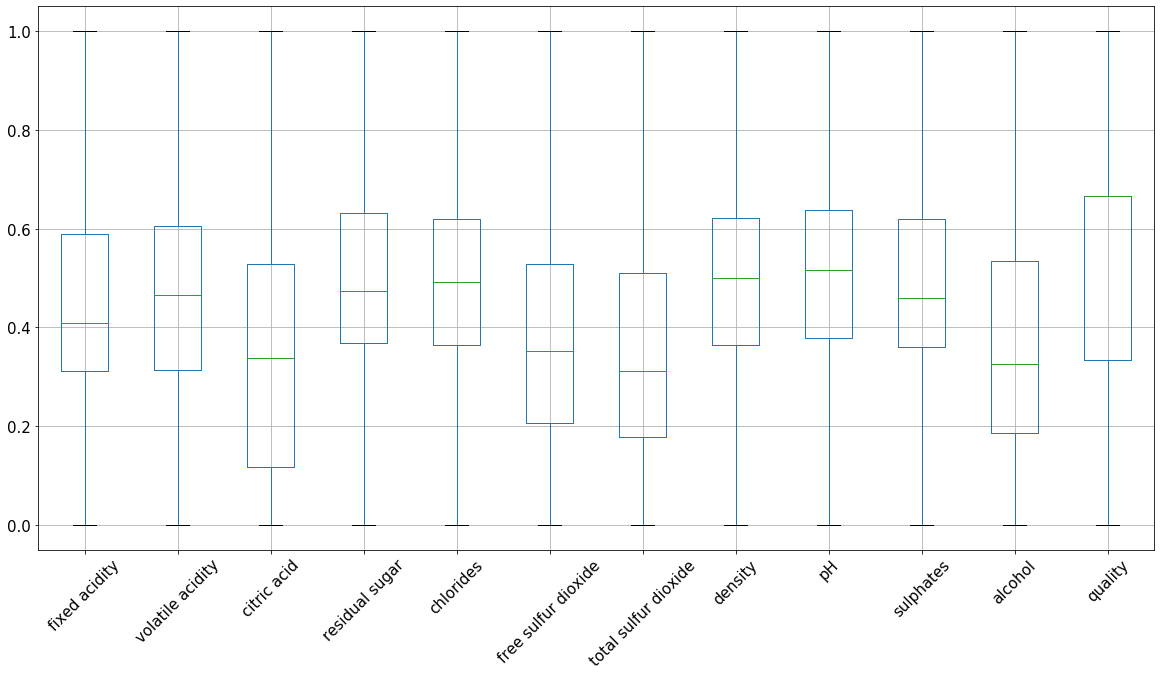

In [30]:
df1_standed = df1.copy()
df1_standed[list(df1.columns)] = stand.fit_transform(df1)
df1_standed.boxplot(figsize=(20,10), rot=45, fontsize=15)

Удалили все выбросы. Заметим, что изначальное число наблюдений было 1599, а стало 923 - то есть изначально в данных было порядка 676-ти выбросов.

Проверим, сбалансированны ли классы качеств вина, которые нам надо классифицировать.

In [31]:
df1['quality'].value_counts()

6    406
5    388
7    102
4     27
Name: quality, dtype: int64

Очевидно, значение качества вина равное четырем значительно меньше других. Скажем, что качество вина 4 незначительно отличается от качества вина 5, то есть 4 заменим на 5, для сбалансированности.

In [32]:
df1['quality'] = df1['quality'].replace(4, 5)
df1['quality'].value_counts()

5    415
6    406
7    102
Name: quality, dtype: int64

Заметим, что в исходном наборе данных у нас 6 классов: теперь, будем считать что три - качества 5, 6 и 7 соответственно.

Разделяем предикторы и отклики.

In [33]:
y = df1["quality"]
x = df1.drop(columns = ["quality"])

Разделяем наблюдения на тестовую и обучающую выборки в пропорции 1:2.

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state = 1337) 

Подберем параметры модели градиентного бустинга GridSearch'ем.

In [35]:
params_set = {  
      'n_estimators': [100, 150, 200],
      'max_depth': [3, 4, 5],
      "min_samples_leaf": [3, 4 ,5],
      "min_samples_split": [5, 7, 9]
}

model = GradientBoostingClassifier(random_state=54,
                                   subsample=0.66,
                                   max_features='sqrt',
                                   loss='deviance',
                                   criterion='friedman_mse',
                                   learning_rate =0.01,
                                   min_impurity_decrease=0.001,
                                   verbose=0
                                   )
model_GS = GridSearchCV(
    model,
    params_set,
    cv=5,
    error_score='raise'
)

In [36]:
model_GS.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.01,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.001,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort='auto',

Лучшие гиперпараметры:

In [37]:
best_hyperparams = model_GS.best_params_
best_hyperparams

{'max_depth': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 200}

Лучшая модель:

In [38]:
best_model = model_GS.best_estimator_
best_model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.001, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=54, subsample=0.66, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [39]:
train_acc = model_GS.best_score_
test_acc = model_GS.score(x_test,y_test)
print(f"Лучшее значение критерия качества deviance на обучающей выборке составило {np.round(train_acc*100, 2)}%.")
print(f"Лучшее значение критерия качества deviance на тестовой выборке составило {np.round(test_acc*100, 2)}%.")

Лучшее значение критерия качества deviance на обучающей выборке составило 68.28%.
Лучшее значение критерия качества deviance на тестовой выборке составило 67.54%.


Как видим, поскольку значения критерия качества deviance на обучающей и тестовой выборке отличаются не сильно, то мы избежали переобучения модели.

In [40]:
probabilities_GS = best_model.predict_proba(x_test)
print("Доля наблюдений в тестовой выборке, для которых есть класс, вероятность принадлежать которому больше 0.8, составила",
      f"{np.round(len(probabilities_GS[probabilities_GS > 0.8]) / len(probabilities_GS), 2)}.")

Доля наблюдений в тестовой выборке, для которых есть класс, вероятность принадлежать которому больше 0.8, составила 0.06.


Confusion matrix:

In [41]:
conf_mat = confusion_matrix(y_test, best_model.predict(x_test))
conf_mat = pd.DataFrame(conf_mat, index=best_model.classes_, columns=best_model.classes_)
conf_mat

,5,6,7
5,102,32,0
6,42,92,2
7,1,22,12


Значимость переменных в классифицкаиции с нахождением параметров GridSearch'ем.

In [42]:
pd.DataFrame({'feature': df1.iloc[:, :-1].columns,
              'importance': best_model.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
10,alcohol,0.197727
9,sulphates,0.153218
1,volatile acidity,0.106897
7,density,0.103275
4,chlorides,0.075341
2,citric acid,0.069394
6,total sulfur dioxide,0.067213
0,fixed acidity,0.062093
8,pH,0.060037
3,residual sugar,0.057651


Признаем все переменные значимыми, ничего отбрасывать не нужно.

In [44]:
y_pred_test = best_model.predict(x_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           5       0.70      0.76      0.73       134
           6       0.63      0.68      0.65       136
           7       0.86      0.34      0.49        35

    accuracy                           0.68       305
   macro avg       0.73      0.59      0.62       305
weighted avg       0.69      0.68      0.67       305



Перейдем к калибровке модели.

In [45]:
model_calibrated = CalibratedClassifierCV(best_model, cv=5, method='sigmoid')
model_calibrated.fit(x_train, y_train)
y_pred_train_calibrated = model_calibrated.predict(x_train)
y_pred_test_calibrated = model_calibrated.predict(x_test)
probabilities_calibrated = model_calibrated.predict_proba(x_test)

In [46]:
print(f"Лучшее accuracy на обучающей выборке составило {np.round(accuracy_score(y_train, y_pred_train_calibrated)*100, 2)}%.")
print(f"Лучшее accuracy на тестовой выборке составило {np.round(accuracy_score(y_test, y_pred_test_calibrated)*100, 2)}%.")
print("Доля наблюдений в тестовой выборке, для которых есть класс, вероятность принадлежать которому больше 0.8, составила",
      f"{np.round(len(probabilities_calibrated[probabilities_calibrated > 0.8]) / len(probabilities_calibrated), 2)}.")

Лучшее accuracy на обучающей выборке составило 87.86%.
Лучшее accuracy на тестовой выборке составило 68.85%.
Доля наблюдений в тестовой выборке, для которых есть класс, вероятность принадлежать которому больше 0.8, составила 0.06.


In [47]:
conf_mat_calibrated = confusion_matrix(y_test, model_calibrated.predict(x_test))
conf_mat_calibrated = pd.DataFrame(conf_mat_calibrated, index=model_calibrated.classes_, columns=model_calibrated.classes_)
conf_mat_calibrated

,5,6,7
5,105,29,0
6,44,91,1
7,3,18,14


In [48]:
print("Другие метрики качества лучшей откалиброванной модели:\n")
print(classification_report(y_test, y_pred_test_calibrated))

Другие метрики качества лучшей откалиброванной модели:

              precision    recall  f1-score   support

           5       0.69      0.78      0.73       134
           6       0.66      0.67      0.66       136
           7       0.93      0.40      0.56        35

    accuracy                           0.69       305
   macro avg       0.76      0.62      0.65       305
weighted avg       0.70      0.69      0.68       305



Вывод: таким образом, в ходе лабораторной работы была выполнена обработка данных (избавление от выбросов, количество которых составило более шестисот наблюдений), после чего была получена модель GridSearch'ем, объем обучающей выборки был 66% от исходной выборки, а тестовой - 33%. Все параметры модели оказались значимы.

После чего была проведена калибровка модели, признанной наилучшей. На выходе была получена модель классификации (откалиброванная), основанная на использованнии градиентного бустинга, которая имееет на тестовой выборке accuracy 68.85%, а на обучающей - 87.86% - другими словами, только каждое третье наблюдение из тестовой выборки будет классифицировано неправильно.

Также была оценена доля наблюдений в тестовой выборке, для которых есть класс, вероятность принадлежать которому больше 0.8 - она составила 0.06.

Стоит отметить, что по сравнению с предыдущими лабораторными работой, в которой исползовалось одно дерево классификации и случайный лес - по сравнению с одним деревом классфикации, использование градиентного бустинга позволило улучшить качество модели почти на 4%, а по сравнению со случайным лесом - результаты оказались почти одинаковые (68.5% у случайного леса и 68.85% у градиентного бустинга).